In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d21

In [2]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间大小位20
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 给前面真实赋值后面的全设置为0

# 生成一个20项的多项式
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features) # 打乱数据
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!阶乘

# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # 加上一组随机噪音

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.5295],
         [2.2322]]),
 tensor([[1.0000e+00, 5.2951e-01, 1.4019e-01, 2.4744e-02, 3.2756e-03, 3.4689e-04,
          3.0614e-05, 2.3158e-06, 1.5328e-07, 9.0180e-09, 4.7751e-10, 2.2986e-11,
          1.0143e-12, 4.1313e-14, 1.5626e-15, 5.5160e-17, 1.8255e-18, 5.6859e-20,
          1.6726e-21, 4.6615e-23],
         [1.0000e+00, 2.2322e+00, 2.4914e+00, 1.8537e+00, 1.0345e+00, 4.6183e-01,
          1.7182e-01, 5.4790e-02, 1.5288e-02, 3.7917e-03, 8.4639e-04, 1.7176e-04,
          3.1950e-05, 5.4860e-06, 8.7470e-07, 1.3017e-07, 1.8160e-08, 2.3845e-09,
          2.9571e-10, 3.4741e-11]]),
 tensor([5.2768, 9.5886]))

In [4]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d21.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt # 用于绘图

def train(train_features, test_features, train_labels, test_labels, num_epochs=400, learning_rate=0.01, weight_decay=0):
    """
    训练模型并评估性能

    Args:
        train_features: 训练集特征 (Tensor)
        test_features: 测试集特征 (Tensor)
        train_labels: 训练集标签 (Tensor)
        test_labels: 测试集标签 (Tensor)
        num_epochs: 训练轮数 (int)
        learning_rate: 学习率 (float)
        weight_decay: L2 正则化强度 (float)
    """
    # 获取特征维度
    num_inputs = train_features.shape[1]
    # 定义模型 (一个简单的线性层，适用于回归)
    model = nn.Sequential(nn.Linear(num_inputs, 1))
    
    # 初始化权重 (可选，有时有助于训练)
    # torch.nn.init.normal_(model[0].weight, mean=0, std=0.01)
    # torch.nn.init.zeros_(model[0].bias)

    # 定义损失函数 (均方误差，适用于回归)
    loss_fn = nn.MSELoss()
    
    # 定义优化器 (随机梯度下降或 Adam)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # 也可以尝试 Adam

    # 用于记录训练和测试损失，方便绘图
    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        # 前向传播
        train_preds = model(train_features)
        # 计算损失
        train_loss = loss_fn(train_preds, train_labels)
        
        # 反向传播
        optimizer.zero_grad() # 清零梯度
        train_loss.backward() # 计算梯度
        optimizer.step()      # 更新参数

        # 评估模式
        model.eval()
        with torch.no_grad(): # 不计算梯度以节省内存和时间
            # 计算测试集上的损失
            test_preds = model(test_features)
            test_loss = loss_fn(test_preds, test_labels)

        # 记录损失
        train_loss_history.append(train_loss.item())
        test_loss_history.append(test_loss.item())

        # 打印日志
        if (epoch + 1) % 50 == 0 or epoch == 0: # 每50轮或第0轮打印一次
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    print(f'Final Train Loss: {train_loss.item():.6f}, Final Test Loss: {test_loss.item():.6f}')

    # 绘制训练和测试损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', marker='o', markevery=max(1, num_epochs//20)) # 每隔一定间隔标记点
    plt.plot(range(1, num_epochs + 1), test_loss_history, label='Test Loss', marker='s', markevery=max(1, num_epochs//20))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 返回训练好的模型（可选，如果你想在函数外使用它）
    return model

# 你可以像这样调用它：
# train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

c:\Users\zheng\anaconda3\envs\image-text-retrieval\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/400], Train Loss: 33.931900, Test Loss: 25.220078
Epoch [50/400], Train Loss: 26.287096, Test Loss: 15.591209
Epoch [100/400], Train Loss: 26.208422, Test Loss: 15.220289
Epoch [150/400], Train Loss: 26.196201, Test Loss: 15.165283
Epoch [200/400], Train Loss: 26.190489, Test Loss: 15.142428
Epoch [250/400], Train Loss: 26.187605, Test Loss: 15.128578
Epoch [300/400], Train Loss: 26.186037, Test Loss: 15.119461
Epoch [350/400], Train Loss: 26.185102, Test Loss: 15.113271
Epoch [400/400], Train Loss: 26.184481, Test Loss: 15.108971
Final Train Loss: 26.184481, Final Test Loss: 15.108971


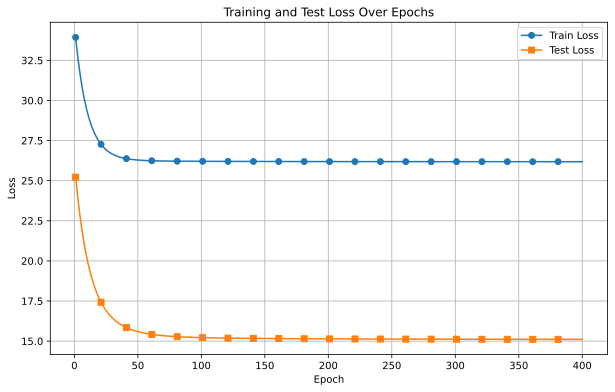

Sequential(
  (0): Linear(in_features=4, out_features=1, bias=True)
)

In [8]:
# 从多项式特征中选择前4个维度,即1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Epoch [1/400], Train Loss: 37.555500, Test Loss: 29.878372
Epoch [50/400], Train Loss: 26.387381, Test Loss: 15.865293
Epoch [100/400], Train Loss: 26.184767, Test Loss: 15.171364
Epoch [150/400], Train Loss: 26.181351, Test Loss: 15.102412
Epoch [200/400], Train Loss: 26.181290, Test Loss: 15.093767
Epoch [250/400], Train Loss: 26.181290, Test Loss: 15.092628
Epoch [300/400], Train Loss: 26.181290, Test Loss: 15.092473
Epoch [350/400], Train Loss: 26.181290, Test Loss: 15.092450
Epoch [400/400], Train Loss: 26.181288, Test Loss: 15.092450
Final Train Loss: 26.181288, Final Test Loss: 15.092450


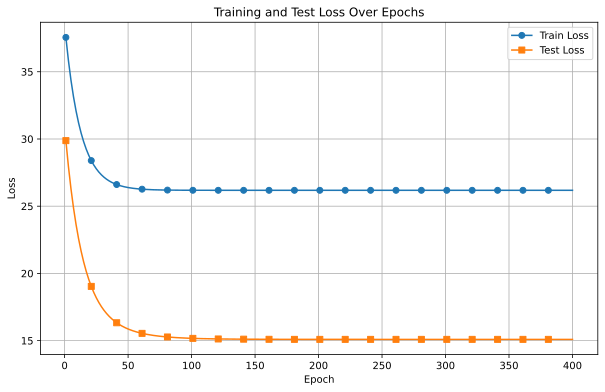

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [9]:
# 从多项式特征中选择前2个维度,即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Epoch [1/1500], Train Loss: 33.492878, Test Loss: 25.277143
Epoch [50/1500], Train Loss: 26.415043, Test Loss: 15.818154
Epoch [100/1500], Train Loss: 26.260241, Test Loss: 15.338128
Epoch [150/1500], Train Loss: 26.214376, Test Loss: 15.224854
Epoch [200/1500], Train Loss: 26.195396, Test Loss: 15.171802
Epoch [250/1500], Train Loss: 26.187460, Test Loss: 15.142069
Epoch [300/1500], Train Loss: 26.184122, Test Loss: 15.124432
Epoch [350/1500], Train Loss: 26.182699, Test Loss: 15.113629
Epoch [400/1500], Train Loss: 26.182085, Test Loss: 15.106866
Epoch [450/1500], Train Loss: 26.181801, Test Loss: 15.102549
Epoch [500/1500], Train Loss: 26.181664, Test Loss: 15.099754
Epoch [550/1500], Train Loss: 26.181587, Test Loss: 15.097920
Epoch [600/1500], Train Loss: 26.181538, Test Loss: 15.096695
Epoch [650/1500], Train Loss: 26.181507, Test Loss: 15.095864
Epoch [700/1500], Train Loss: 26.181479, Test Loss: 15.095289
Epoch [750/1500], Train Loss: 26.181456, Test Loss: 15.094881
Epoch [800/

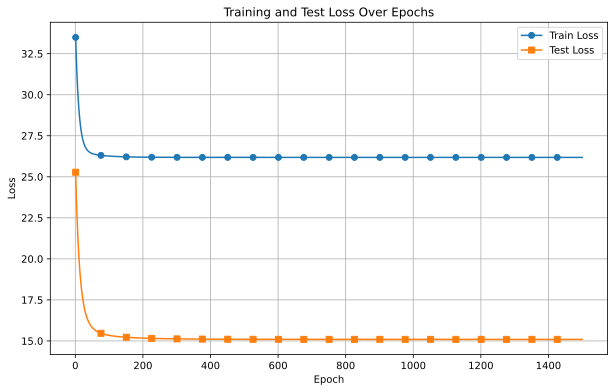

Sequential(
  (0): Linear(in_features=20, out_features=1, bias=True)
)

In [10]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [11]:

import torch
from torch import nn
from d2l import torch as d21

In [12]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d21.synthetic_data(true_w, true_b, n_train)
train_iter = d21.load_array(train_data, batch_size)
test_data = d21.synthetic_data(true_w, true_b, n_test)
test_iter = d21.load_array(test_data, batch_size, is_train=False)

In [13]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [14]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [15]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d21.linreg(X, w, b), d21.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d21.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项,
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d21.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d21.evaluate_loss(net, train_iter, loss),
                                     d21.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是:', torch.norm(w).item())

w的L2范数是: 12.65170955657959


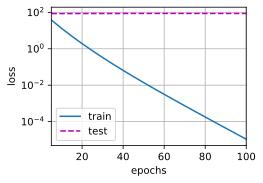

In [16]:
train(lambd=0)

w的L2范数是: 0.3698427975177765


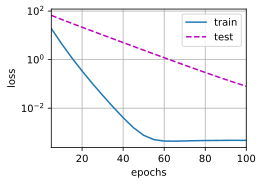

In [17]:
train(lambd=3)

In [18]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d21.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d21.evaluate_loss(net, train_iter, loss),
                          d21.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数:', net[0].weight.norm().item())

In [ ]:
train_concise(0)

w的L2范数: 0.37692710757255554


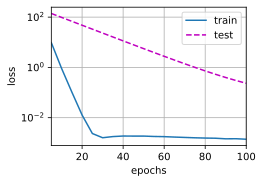

In [19]:
train_concise(3)

In [20]:
import torch
from torch import nn
from d2l import torch as d21

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中,所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中,所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

### 第27页：测试Dropout层


X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12., 14.],
        [ 0., 18., 20., 22.,  0.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [21]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [22]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [25]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer):
    """
    用于训练 Softmax 回归模型 (例如 Fashion-MNIST) 的函数

    Args:
        net: 定义的神经网络模型
        train_iter: 训练数据迭代器
        test_iter: 测试数据迭代器
        loss: 损失函数 (例如 CrossEntropyLoss)
        num_epochs: 训练轮数
        trainer: 优化器 (例如 SGD)
    """
    # 使用 d2l 提供的 Animator 来绘制训练曲线
    animator = d21.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d21.Accumulator(3) # 累加器，用于累计 (训练损失总和, 训练准确数量, 测试准确数量)

        # 训练模式
        net.train()
        for X, y in train_iter:
            # 前向传播
            y_hat = net(X)
            l = loss(y_hat, y) # 计算每个样本的损失
            trainer.zero_grad() # 清零梯度
            l.mean().backward() # 计算平均损失的梯度 (CrossEntropyLoss(reduction='none') 需要先求均值)
            trainer.step()      # 更新参数

            # 累加损失和准确数量 (使用 d2l.accuracy 函数)
            metric.add(float(l.sum()), d21.accuracy(y_hat, y), y.numel())

        # 计算平均训练损失和训练准确率
        train_loss = metric[0] / metric[2] # metric[0] 是总损失, metric[2] 是总样本数
        train_acc = metric[1] / metric[2]  # metric[1] 是总正确数

        # 评估模式
        test_acc = d21.evaluate_accuracy_gpu(net, test_iter) # 使用 d2l 提供的评估函数

        # 更新绘图
        animator.add(epoch + 1, (train_loss, train_acc, test_acc))

    print(f'最终 - 训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}, 测试准确率: {test_acc:.4f}')

最终 - 训练损失: 0.3354, 训练准确率: 0.8766, 测试准确率: 0.8590


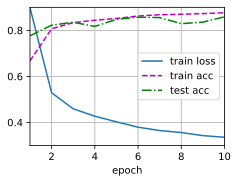

In [26]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d21.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [27]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

最终 - 训练损失: 0.3443, 训练准确率: 0.8726, 测试准确率: 0.8243


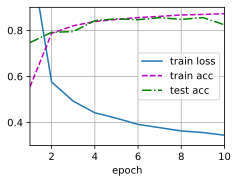

In [28]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)